Imports section. You basically neet to install the JupyterLab, MatPlotLib and Pandas libraries. To use some interactins in the notebook we are using ipywidgets as well.  
These are the pip commands to install the packes:  
**pip install jupyterlab  
pip install pandas  
pip install matplolib  
pip install ipywidgets**  
  
In order to get ipywidgets working with jupyter notebook please run the following command:  
**jupyter nbextension enable --py --sys-prefix widgetsnbextension**  
    
If you're using jupyter lab you also have to register the extension:  
**jupyter labextension install @jupyter-widgets/jupyterlab-manager**  
  
Please refer to: [https://github.com/jupyter-widgets/ipywidgets/blob/master/README.md](https://github.com/jupyter-widgets/ipywidgets/blob/master/README.md)  
  
When exectuing the second command you may wonder that the terminal is somehow standing still. Don't worry, start the jupyter notebook in a second terminal using:  
**jupyter lab**  
  
Please refer to: [https://github.com/jupyter-widgets/ipywidgets/blob/master/README.md](https://github.com/jupyter-widgets/ipywidgets/blob/master/README.md)  
  
For your convenience we added all of these indivdual installtion to one requirements text file that you can execute using the one and only following command (you will find requirements.txt in the root folder of this project):  
**pip install -r requirements.txt**  
  

In [31]:
import datetime
from datetime import date
import math
import requests
import os
import json
from json import load, dumps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from pandas.io.json import json_normalize
from ipywidgets import widgets
from IPython.display import display, Javascript
import IPython
import re
import matplotlib.ticker as ticker



And now the class. The constructor takes a string containing the full filenname of a JSON database you can down load from the WHO website:<br>
  
https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide  
  
The database will be loaded and kept as a private member. To retrieve the data for an indvidual country you can use the public methods **GetCountryDataByGeoID** or **GetCountryDataByCountryName**. Refer to the JSON file for a list of available GeoIDs and CountryNames. Both methods will return a list of the following fields as a JSON:  
  
**Date** The date of the data  
**Country** The name of the country  
**GeoID** The GeoID of the country such as FR for France or DE for Germany  
  
**Cases** The number of cases on that day  
**CumulativeCases** The accumulated number of cases since the 31.12.2019  
**Quotient** The number of cases on the day devided by the number of cases of the previous day  
**DoublingTime** The number of days in which the number of cases will be doubled  
  
**Deaths** The number of deaths on the date  
**CumulativeDeaths** The accumulated number of deaths since the 31.12.2019   
**PercentDeaths** The number of deaths in % of the cases  
  
**CasesPerMillionPopulation** The number of cumulative cases devide by the popolation of the countryy in million      
**DeathsPerMillionPopulation** The number of cumulative deaths devide by the popolation of the countr in million  
  


In [32]:

class CovidCases:
    """
    The constructor takes a string containing the full filenname of a JSON
    database you can down load from the WHO website:
    https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
    The database will be loaded and kept as a private member. To retrieve the
    data for an indvidual country you can use the public methods
    GetCountryDataByGeoID or GetCountryDataByCountryName. Refer to the JSON
    file for a list of available GeoIDs and CountryNames. Both methods will
    return a list of the following fields as a JSON:

    Date
    The date of the data Country The name of the country

    GeoID
    The GeoID of the country such as FR for France or DE for Germany

    Cases
    The number of cases on that day

    CumulativeCases
    The accumulated number of cases since the 31.12.2019

    Quotient
    The number of cases on the day devided by the number of cases of the
    previous day DoublingTime The number of days in which the number of cases
    will be doubled
    Deaths
    The number of deaths on the date

    CumulativeDeaths
    The accumulated number of deaths since the 31.12.2019

    PercentDeaths
    The number of deaths in % of the cases
    CasesPerMillionPopulation
    The number of cumulative cases devide by the popolation of the countryy in million

    DeathsPerMillionPopulation
    The number of cumulative deaths devide by the popolation of the countr in million
    """

    def __get_common_attributes(self, record):
        """
        get a subset of attributes
        """
        return {
            "Country": record["countriesAndTerritories"],
            "GeoID": record["geoId"],
            "Population": int(record["popData2018"]) if record["popData2018"] != "" else 1,
            "Date": record["dateRep"],
            "Cases": int(record["cases"]),
            "Deaths": int(record["deaths"])
        }

    def __init__(self, filename):
        """
        constructor
        """
        # open the file and read the 'records'
        with open(filename) as f:
            self.__db = load(f)["records"]
        # map the subset
        self.__db = list(map(lambda x: self.__get_common_attributes(x), self.__db))
        # dump the database
        # print(dumps(self.__db))

    def __get_all_records(self, f):
        """
        get all records
        """
        return lambda y: all([x(y) for x in f])

    def __add_extra_atributes(self, subset):
        """
        add some specific attributs
        """
        # add a col to the first element having the number of cases
        subset[0].update({'CumulativeCases': int(subset[0]['Cases'])})
        subset[0].update({'CumulativeDeaths': int(subset[0]['Deaths'])})
        subset[0].update({'PercentDeaths': math.nan})
        subset[0].update({'CasesPerMillionPopulation': 0})
        subset[0].update({'DeathsPerMillionPopulation': 0})
        # loop through the list starting at index 1
        for x in range(1, len(subset)):
            # the cumulative ncases of day n-1
            dayNm1Cum = int(subset[x - 1]['CumulativeCases'])
            # the cases of day n
            dayN = int(subset[x]['Cases'])
            # the cumulative cases of day n
            dayNCum = dayNm1Cum + dayN
            subset[x].update({'CumulativeCases': dayNCum})
            # the quuotient of day(n) / day(n-1)
            if dayNm1Cum != 0:
                subset[x].update({'Quotient': dayNCum / dayNm1Cum})
            else:
                subset[x].update({'Quotient': math.nan})
            quotient = float(subset[x]['Quotient'])
            # the doubling time in days
            if quotient != 1.0 and quotient != math.nan:
                subset[x].update({'DoublingTime': math.log(2) / math.log(quotient)})
            else:
                subset[x].update({'DoublingTime': math.nan})
            # the cumulative deaths of day n-1
            dayNm1CumDeaths = int(subset[x - 1]['CumulativeDeaths'])
            # the deatha of day n
            dayN = int(subset[x]['Deaths'])
            # the cumulative deaths of day n
            dayNCumDeaths = dayNm1CumDeaths + dayN
            subset[x].update({'CumulativeDeaths': dayNCumDeaths})
            # the number of deaths in percent of the cases
            if dayNCum != 0:
                subset[x].update({'PercentDeaths': dayNCumDeaths * 100 / dayNCum})
            else:
                subset[x].update({'PercentDeaths': math.nan})
            # the population in million
            population = int(subset[x]['Population']) / 1000000
            # cases per million
            casesPerMillion = dayNCum / population
            subset[x].update({'CasesPerMillionPopulation': casesPerMillion})
            # deaths per million
            deathsPerMillion = dayNCumDeaths / population
            subset[x].update({'DeathsPerMillionPopulation': deathsPerMillion})
            # print(subset[x])
        return subset

    def get_country_data_by_geoID(self, geoID, lastNdays=0, sinceNcases=0):
        """
        return the list of cases by geoID
        """
        # specify the filter
        filters = []
        filters.append(lambda r: r["GeoID"] == geoID)
        # apply the filter
        subset = list(filter(self.__get_all_records(filters), self.__db))
        # reverse the list (1st date on top of the list)
        subset.reverse()
        subset = self.__add_extra_atributes(subset)
        if lastNdays > 0:
            start_index = len(subset) - lastNdays
            subset = subset[start_index:]
        if sinceNcases > 0:
            # loop through the list
            while len(subset) > 0:
                # the cumulative ncases of x
                numCum = int(subset[0]['CumulativeCases'])
                if numCum < sinceNcases:
                    # delete it
                    subset.pop(0)
                else:
                    # we are done
                    break
            # add the index col
            for x in range(0, len(subset)):
                subset[x].update({'Index': int(x)})
        return subset

    def get_country_data_by_country_name(self, countryName, lastNdays=0):
        """
        return the list of cases by country name
        """
        # specify the filter
        filters = []
        filters.append(lambda r: r["countriesAndTerritories"] == countryName)
        # apply the filter
        subset = list(filter(self.__get_all_records(filters), self.__db))
        # reverse the list (1st date on top of the list)
        subset.reverse()
        # add additonal fields
        subset = self.__add_extra_atributes(subset)
        if lastNdays > 0:
            start_index = len(subset) - lastNdays
            subset = subset[start_index:]
        return subset



We also use a Builder class in this project. It's very much configured for our needs of plotting a Pandas DataFrame. When using it you have to pass the name of the DataFrame column you want to plot as a constructor argument. Afterwards you're able to configure multiple plotting configurations like name, figure size, y-axis scale and so on. In the end you pass the DataFrame that should be plotted to the function plot_dataFrame and it outputs a beautiful matplotlib plot.

In [33]:
class PlotterBuilder:
    """
    A class that let's you easily build the wanted plotting configuration. If not further specified you get some
    default values like:
        - A figsize of 12, 8
        - No name
        - No grid
        - A linear y-axis-scale
        - A xaxis DateFormatter with format Y-m-d
    When plotting a DataFrame this class is always grouping by columns.
    """

    def __init__(self, yfield):
        """
        Creates an instance with mentioned default values.
        Parameter:
            yfield: The field of the DataFrame you want to plot.
        """
        self.__figsize = (12, 8)
        self.__title = ""
        self.__grid = False
        self.__yscale = 'linear'
        self.__xaxis_formatter = mdates.DateFormatter('%d/%m/%Y')
        self.__yfield = yfield
        self.__xlabel = ""
        self.__ylabel = ""

    def set_figsize(self, sizes):
        """
        Setter for the figure size.
        """
        self.__figsize = sizes
        return self

    def set_title(self, title):
        """
        Setter for the title.
        """
        self.__title = title
        return self

    def set_grid(self):
        """
        Sets the grid value to True.
        """
        self.__grid = True
        return self

    def set_log(self):
        """
        Formats the yscale to logarithmic.
        """
        self.__yscale = 'log'
        return self

    def set_xaxis_index(self):
        """
        Tells the x-axis that you don't want to plot a date.
        """
        self.__xaxis_formatter = None
        return self

    def set_axis_labels(self, xlabel="", ylabel=""):
        """
        Sets the axis labels.
        """
        self.__xlabel = xlabel
        self.__ylabel = ylabel
        return self

    def build(self):
        """
        Builds the configured plotting object.
        Returns:
             fig: figure object
             ax: axis object with the wanted configurations.
        """
        fig, ax = plt.subplots(1, 1, figsize=self.__figsize)
        ax.set_title(self.__title)
        ax.set_yscale(self.__yscale)
        if self.__xaxis_formatter:
            ax.xaxis.set_major_formatter(self.__xaxis_formatter)
        ax.set(xlabel=self.__xlabel)
        ax.set(ylabel=self.__ylabel)
        return [fig, ax]

    def plot_dataFrame(self, df, **options):
        """
        Plots the DataFrame. If you want to plot an index on the x-axis you have to set it within the DataFrame object.
        If not the column date is used.
        """
        if self.__xaxis_formatter is None:
            # plot an index, not a date
            pldf = df.pivot_table(values=self.__yfield, index=df.index, columns='Country')
        else:
            # plot it with a date formatted x axis
            pldf = df.pivot_table(values=self.__yfield, index='Date', columns='Country')
        fig, ax = self.build()
        pldf.plot(ax=ax, **options)
        ax.grid(self.__grid)



We need to download the database from a file provided by the ECDC:


In [34]:
def get_JSON_filename():
    """
    automatically downloads the database file if it doesn't exists
    """
    # todays date
    today = date.today()
    # the prefix of the JSON file is Y-m-d
    preFix = today.strftime("%Y-%m-%d")
    # the absolut directory of this python file
    #absDirectory = os.path.dirname(os.path.abspath(__file__))
    absDirectory = os.path.dirname(os.path.abspath(os.path.abspath('')))
    # the target filename
    targetFilename = os.path.join(absDirectory, "./data/" + preFix + "-db.json")
    # check if it exist already
    if os.path.exists(targetFilename):
        print('using existing file: ' + targetFilename)
    else:
        # download the file from the ecdc server
        url = "https://opendata.ecdc.europa.eu/covid19/casedistribution/json/"
        r = requests.get(url)
        if r.status_code == 200:
            with open(targetFilename, 'wb') as f:
                f.write(r.content)
        else:
            raise FileNotFoundError('Error getting JSON file. Error code: ' + str(r.status_code))
    return targetFilename



Now load the file. As the repository uses Github actions we need to somehow inject special data into the notbook, this is done via this cell.


In [35]:
pathToJson = "data/db.json"
githubAction = False



Using the class is pretty simple. Create an instance of the class using the full path to the filename and get the data for a specific country by calling<br> <i>data = covidCases.GetCountryDataByGeoID("DE")</i>. The geoID is equal to the country code of a toplevel domain. E.g. <i>DE</i> for Germany, <i>FR</i> for France, <i>JP</i> for Japan or <i>KR</i> for Korea.  
This code here accepts a list of comma separated countries to easily compare the data of multiple countries at once. 


In [140]:
if not githubAction:
    pathToJson = get_JSON_filename()
# create an instance
covidCases = CovidCases(pathToJson)
# a list for our data
data = []
# split the string
geoIDs = re.split(r",\s*", "US, UK, ES, IT, RU")
# the number of last days to generate the data or 0 for all time
lastNdays = 0
# collect the data for all country codes
for geoID in geoIDs:
    data.append(covidCases.get_country_data_by_geoID(geoID, lastNdays))


using existing file: /Users/martinkersting/Documents/GitHub/Covid-19-analysis/./data/2020-05-27-db.json



Next we want to visualise the data in several diagrams. In a first step we need to concatinate the data fields of different countries that we want to visualise. Be aware of a proper date format in pandas. Next is to select the field that we want to display, indexed by the date having the countriy name as a column.


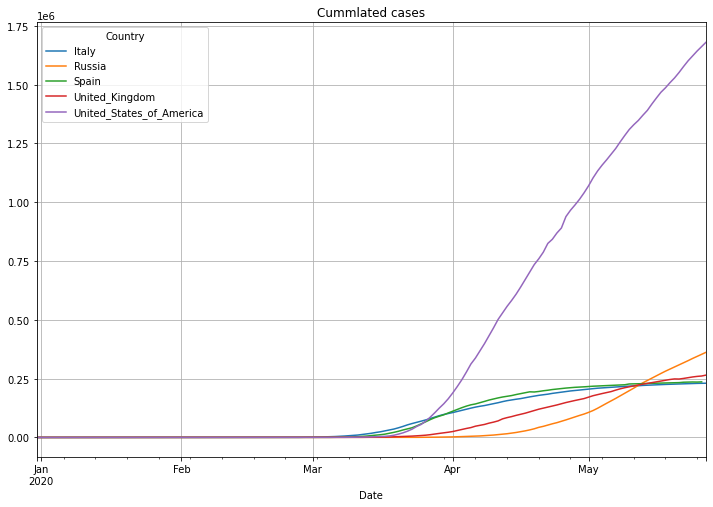

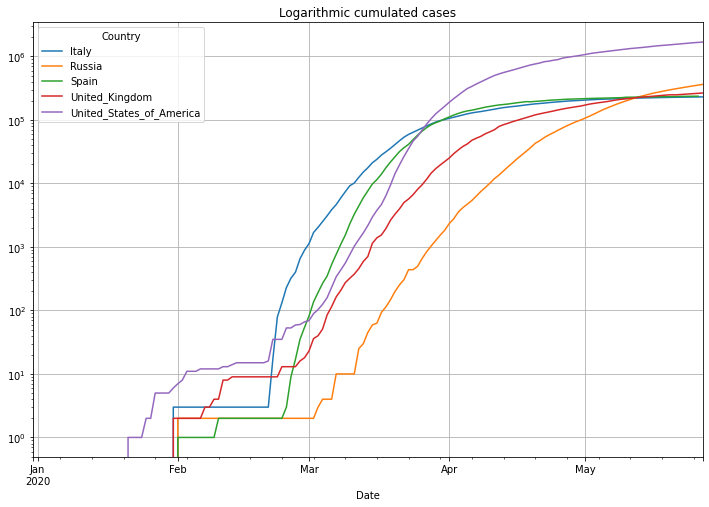

In [141]:
# convert results to a panda dataframes
# differntiate between a normal run and a github actions injected run
if not githubAction:
    dfdata = [pd.DataFrame(country_data) for country_data in data]
else:
    dfdata = [pd.DataFrame(country_data) for country_data in dataAction]
    
# concatinate both lists
df = pd.concat(dfdata)
# ensure the type of the 'Date' field
df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')

# plot with various axes scales, first with linear axis scale:
(PlotterBuilder('CumulativeCases') 
    .set_title('Cummlated cases') 
    .set_grid() 
    .plot_dataFrame(df))

# then logarithmic cumulated cases
(PlotterBuilder('CumulativeCases')
    .set_title('Logarithmic cumulated cases')
    .set_grid()
    .set_log()
    .plot_dataFrame(df))



The following shows a bargraph of cases per day:
    

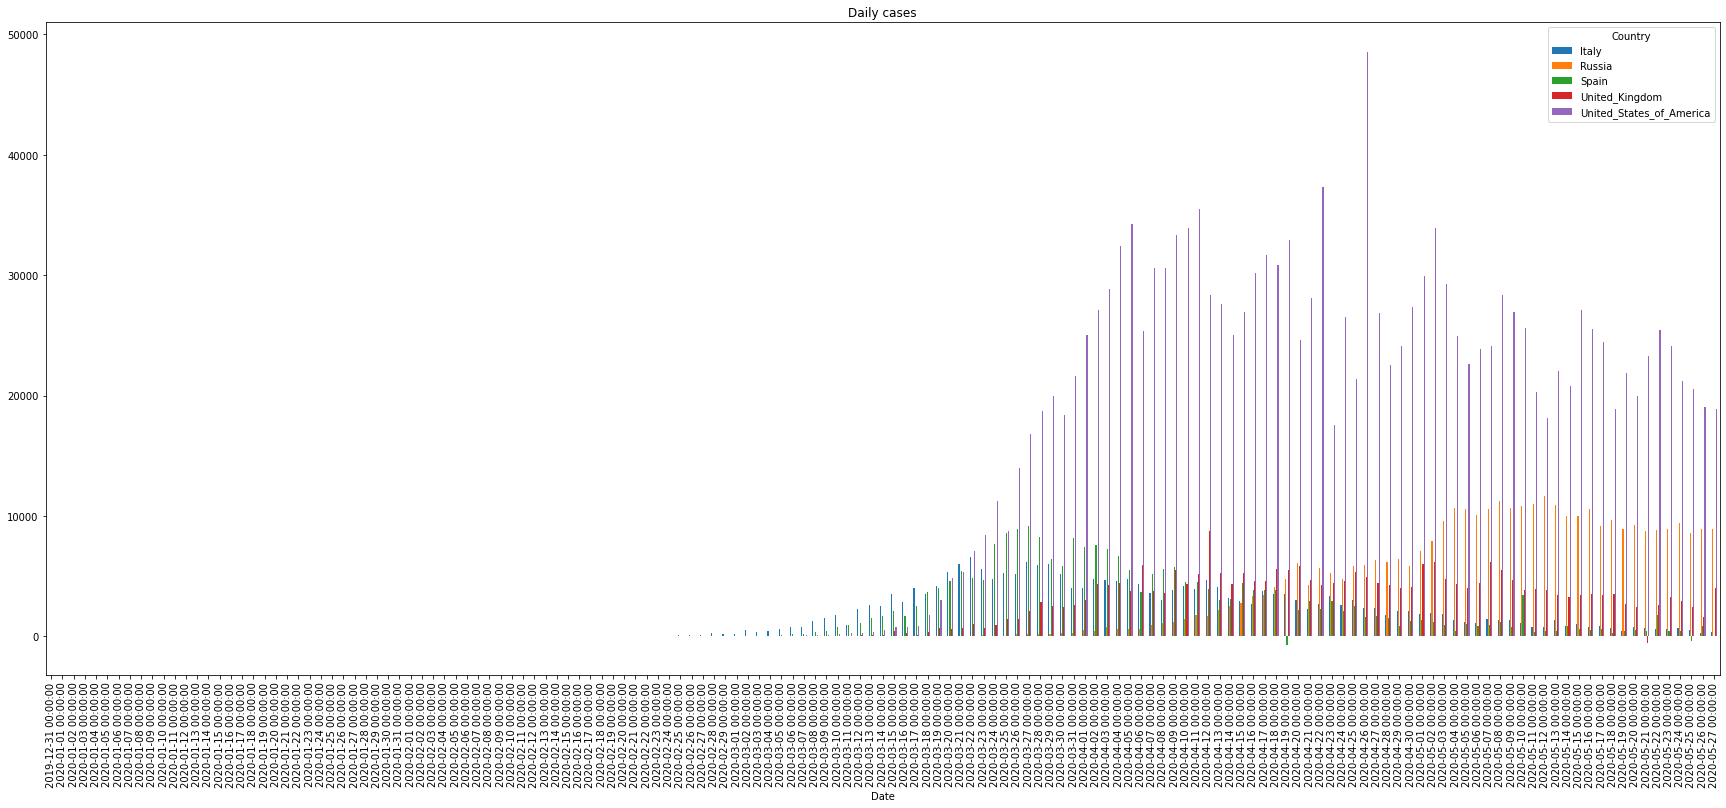

In [142]:
# ensure that cases are of a numeric type
df['Cases'] = pd.to_numeric(df['Cases'])

# plot the daily cases in a bar chart
(PlotterBuilder('Cases')
     .set_figsize((30, 12))
     .set_title('Daily cases')
     .plot_dataFrame(df, kind='bar'))



Now the graphs of the deaths:


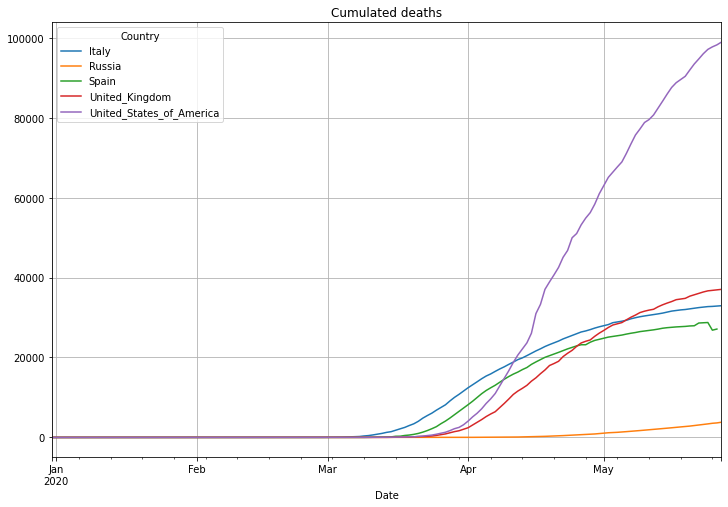

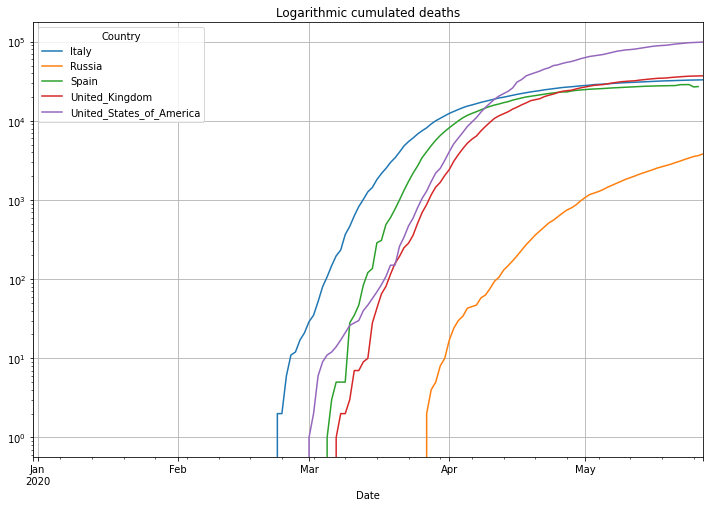

In [143]:
# plot cumulated deaths
(PlotterBuilder('CumulativeDeaths')
     .set_title('Cumulated deaths')
     .set_grid()
     .plot_dataFrame(df))

# plot cumulated deaths in logarithmic y-axis scale
(PlotterBuilder('CumulativeDeaths')
     .set_title('Logarithmic cumulated deaths')
     .set_grid()
     .set_log()
     .plot_dataFrame(df))


The number of deaths in percent of the cases. There is an interesting, not finished (17.04.2020), study in the village of Gangelt, Heinsberg county Germany, with 12000 citizen. A couple from the town was spending vacation in the Italian Lombardian area, the first hotspot in Italy. When they came back from vacation they attended 3 carnival parties in the village. Beside that the woman was working in a kinder garden. Both have been infected and the village became the first hotspot in Germany after a smaller outbreak at a Webasto fab in Bavaria. A team of the virology institute at the university of Bonn headed by professor Hendrik Streeck tested 509 persons of 240 households on antibodies of Sars-CoV-2. As a result they found out that statistically 15% of the citizen had already antibodies, meaning an infection with Covid-19. Taking the amount of infected people and the number of deaths in the village into account it turns out, that the death rate was only 0,37%, a pretty low number. This leads to a simple problem: if the reported number of cases is low, then the death rate will be significantly higher. Interestingly Germany is doing Covid-19 tests massively and the death rate is significantly lower than in other countries with a higher death rate. This might be an indicator of less tests and therefore a high number of 'dark cases', cases that are not confirmed due to not enough tests.

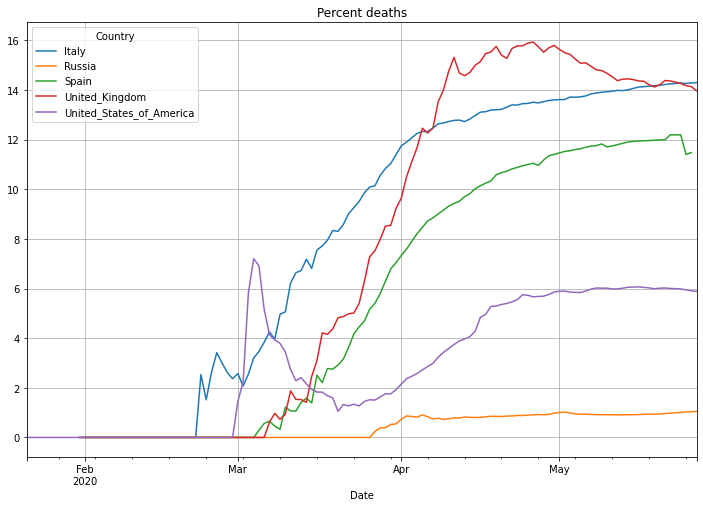

In [144]:
# plot the percent deaths with linear scale
(PlotterBuilder('PercentDeaths')
    .set_title('Percent deaths')
    .set_grid()
    .plot_dataFrame(df))



Now the number of cases per million population:
    

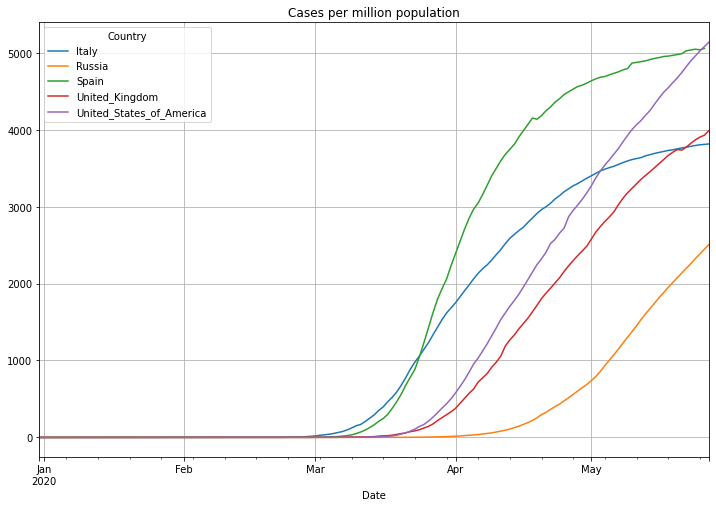

In [145]:
# plot the daily doubling time with linear scale
(PlotterBuilder('CasesPerMillionPopulation')
    .set_title('Cases per million population')
    .set_grid()
    .plot_dataFrame(df))



Now the number of deaths per million population. Be aware: some countries report not all deaths. The United Kingdom for instance reports only people that died in NHS facilities:
    

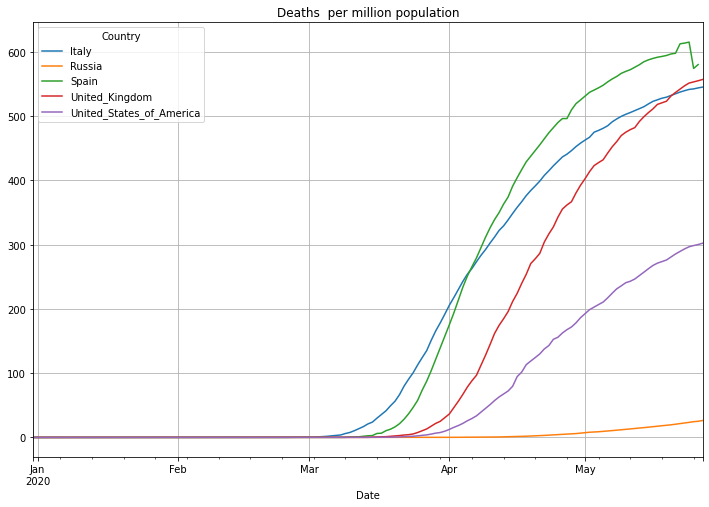

In [146]:
# plot the daily doubling time with linear scale
(PlotterBuilder('DeathsPerMillionPopulation')
    .set_title('Deaths  per million population')
    .set_grid()
    .plot_dataFrame(df))



Finally the doubling time which stands for the number of days it needs to double the number of cases. The higher this number, the better the situation is:
    

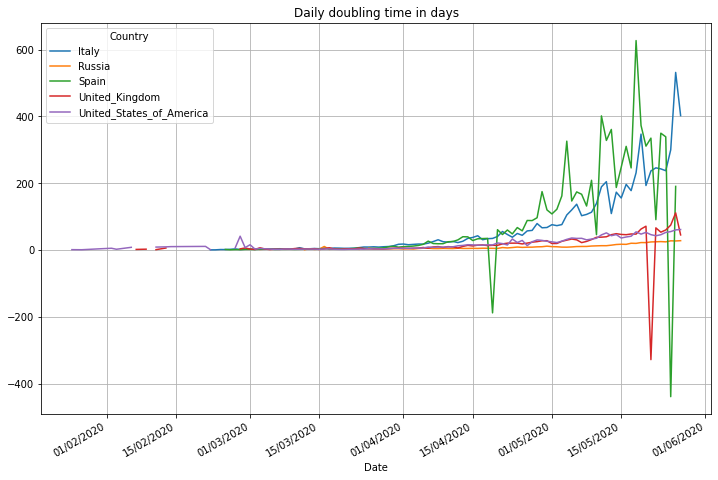

In [147]:
# plot the daily doubling time with linear scale
(PlotterBuilder('DoublingTime')
    .set_title('Daily doubling time in days')
    .set_grid()
    .plot_dataFrame(df))



Now we will align the data to the day when the cumulative cases first execeeded the number of 100 cases. This will help us understanding the different speed of the outbreak in different countries. Graphs which started delayed, or better, started horizontally shifted above will now be aligned on the left. The units on the horizontal axis is now <i>Number of Days</i>. Because of the alignment the graphs will be longer or shorter depending on the number of days since the country exceeded 100 cases.


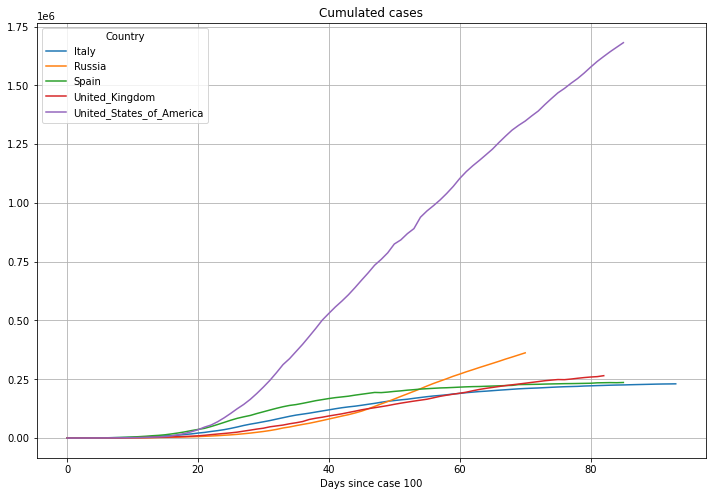

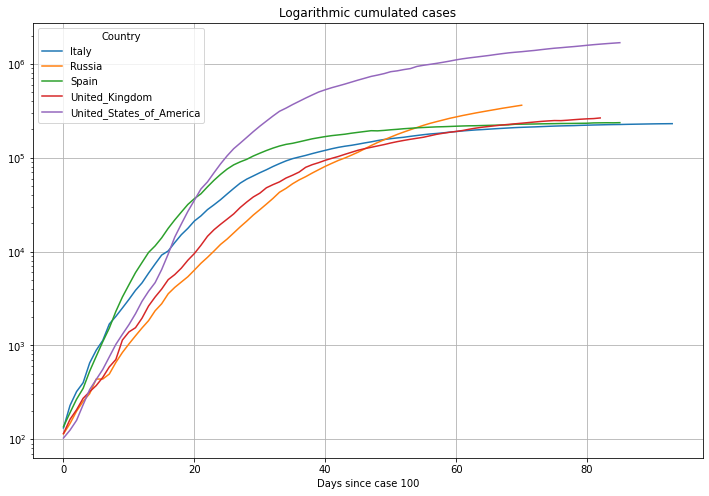

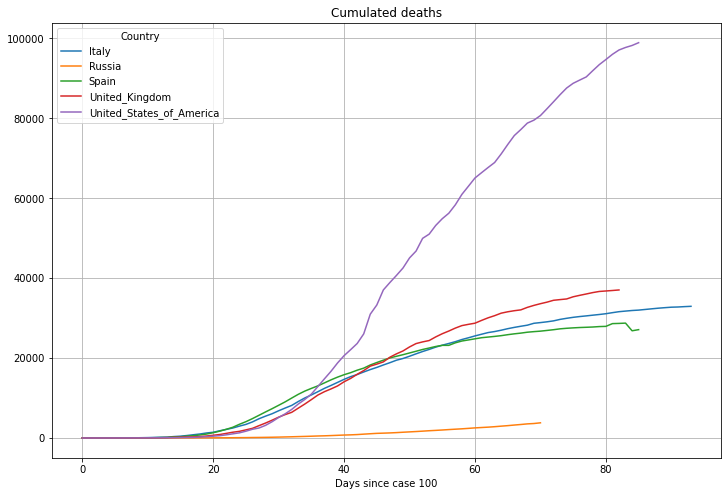

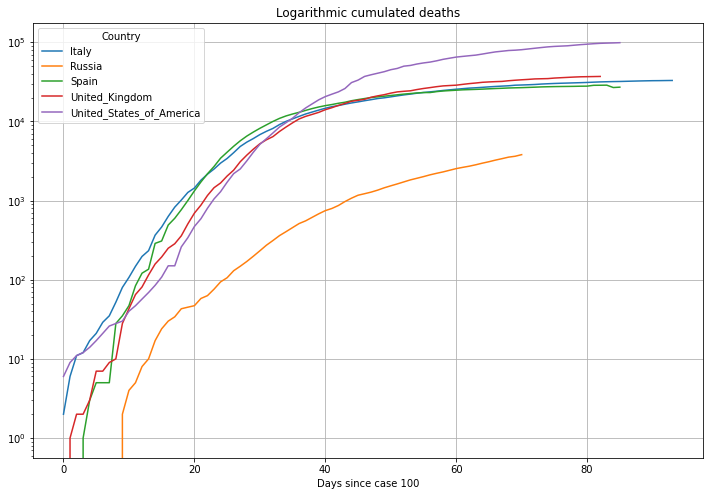

In [148]:
# delete the previous data
data.clear()
# collect the data for all country codes
numCasesStart = 100
for geoID in geoIDs:
    data.append(covidCases.get_country_data_by_geoID(geoID, sinceNcases=numCasesStart))

# convert results to a panda dataframes
# differntiate between a normal run and a github actions injected run
if not githubAction:
    dfdata = [pd.DataFrame(country_data) for country_data in data]
else:
    dfdata = [pd.DataFrame(country_data) for country_data in dataAction]
    
# concatinate both lists
df = pd.concat(dfdata)    
# plot cumulated cases
(PlotterBuilder('CumulativeCases')
     .set_title('Cumulated cases')
     .set_xaxis_index()
     .set_grid()
     .set_axis_labels(xlabel="Days since case " + str(numCasesStart))
     .plot_dataFrame(df))

# plot cumulated cases
(PlotterBuilder('CumulativeCases')
     .set_title('Logarithmic cumulated cases')
     .set_xaxis_index()
     .set_grid()
     .set_log()
     .set_axis_labels(xlabel="Days since case " + str(numCasesStart))
     .plot_dataFrame(df))

# concatinate both lists
df = pd.concat(dfdata)    
# plot cumulated cases
(PlotterBuilder('CumulativeDeaths')
     .set_title('Cumulated deaths')
     .set_xaxis_index()
     .set_grid()
     .set_axis_labels(xlabel="Days since case " + str(numCasesStart))
     .plot_dataFrame(df))

# plot cumulated cases
(PlotterBuilder('CumulativeDeaths')
     .set_title('Logarithmic cumulated deaths')
     .set_xaxis_index()
     .set_grid()
     .set_log()
     .set_axis_labels(xlabel="Days since case " + str(numCasesStart))
     .plot_dataFrame(df))

Lets take a closer look to the last 30 days.

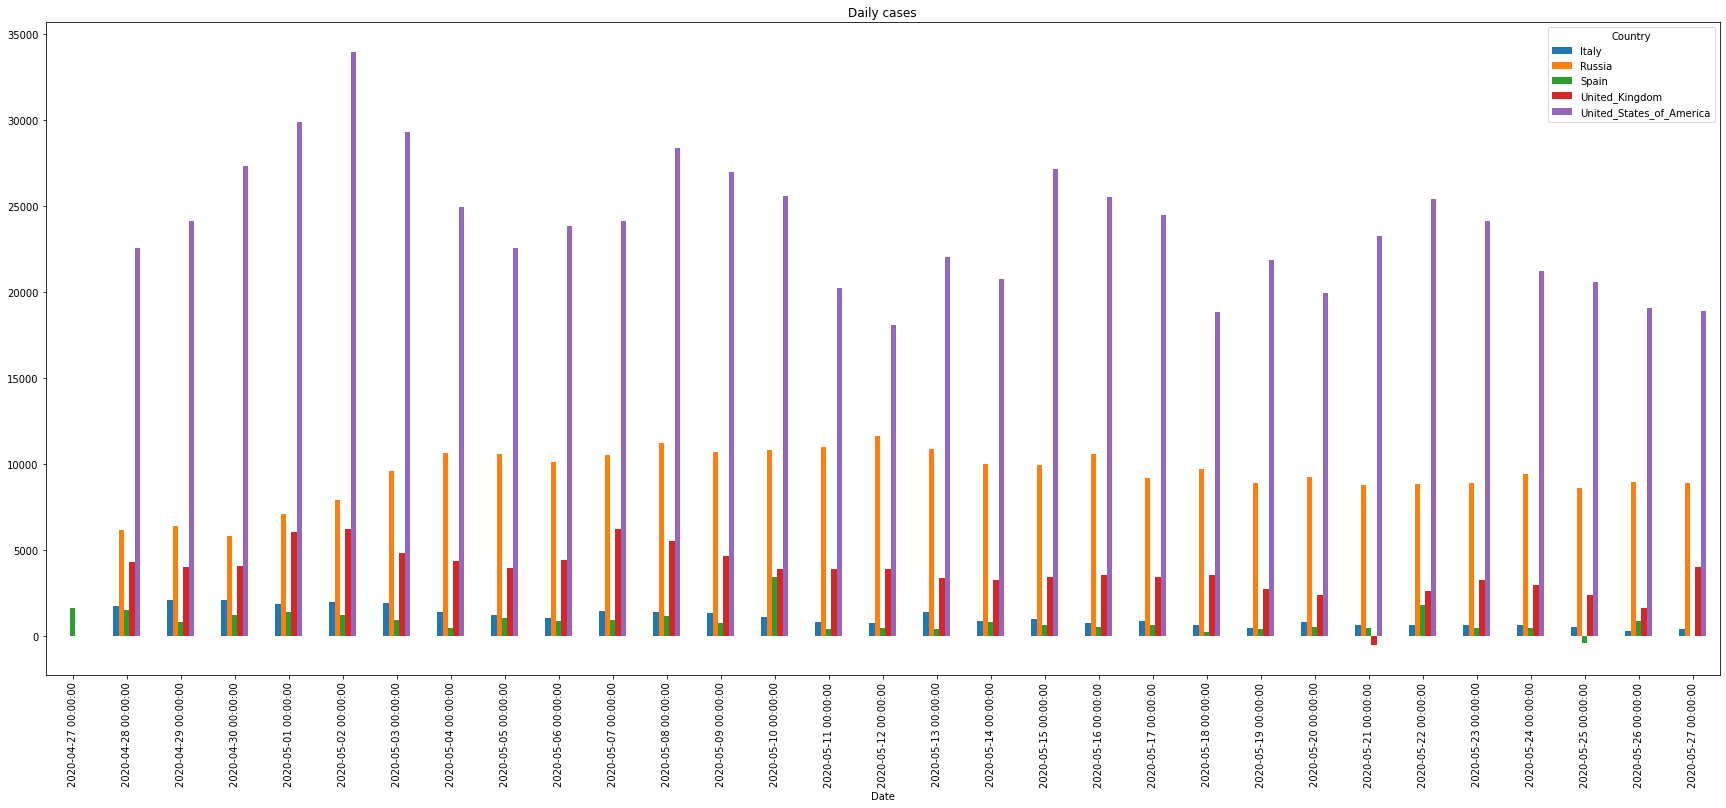

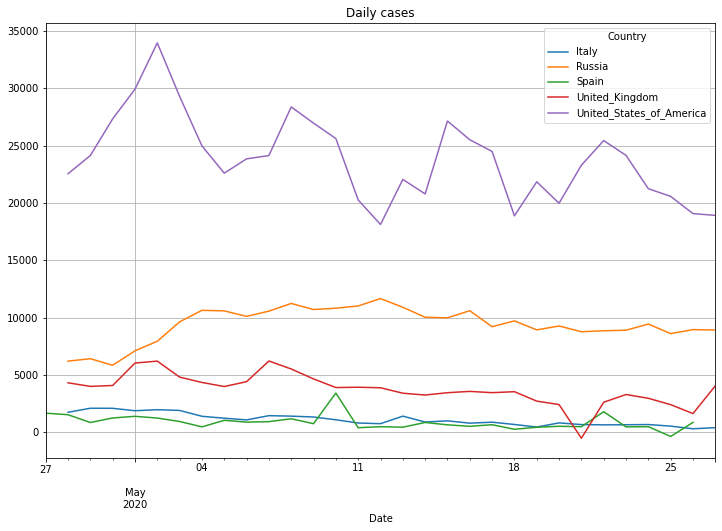

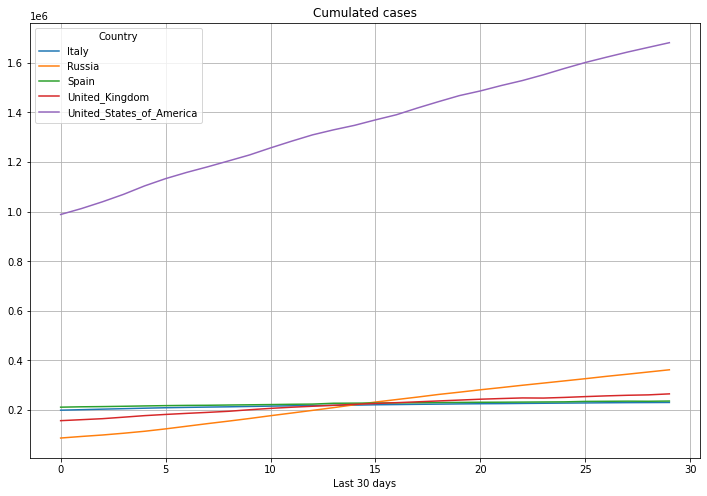

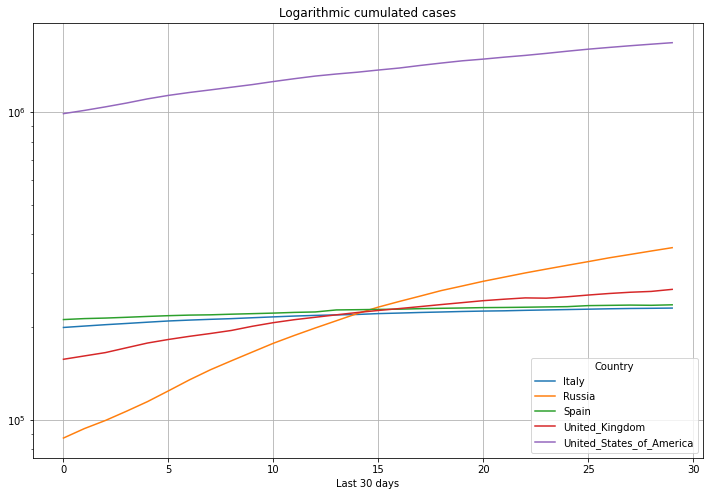

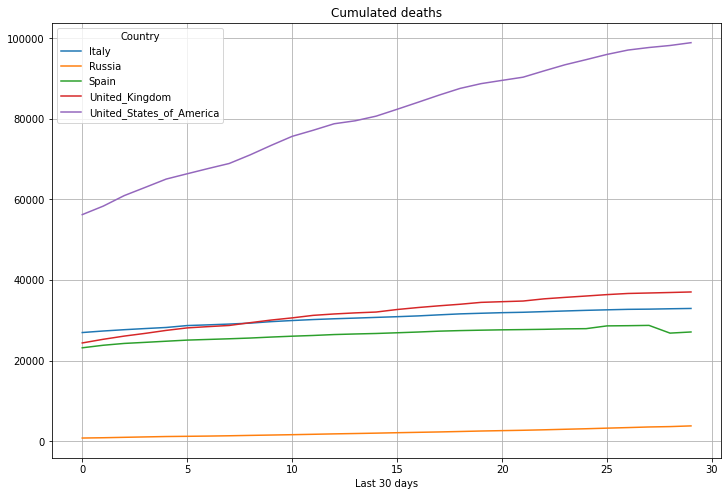

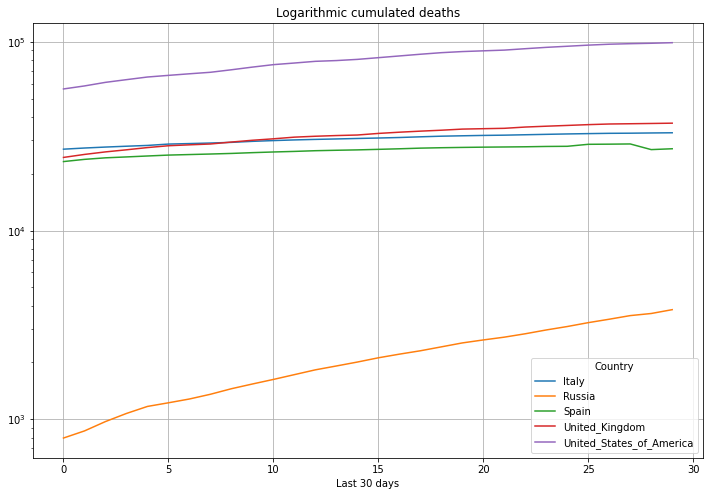

In [149]:
# delete the previous data
data.clear()
# collect the data for all country codes
numLastDays = 30
for geoID in geoIDs:
    data.append(covidCases.get_country_data_by_geoID(geoID, lastNdays=numLastDays))

# convert results to a panda dataframes
# differntiate between a normal run and a github actions injected run
if not githubAction:
    dfdata = [pd.DataFrame(country_data) for country_data in data]
else:
    dfdata = [pd.DataFrame(country_data) for country_data in dataAction]

# concatinate both lists
df = pd.concat(dfdata)  
# ensure the cases are int
df['Cases'] = pd.to_numeric(df['Cases'])
# ensure the type of the 'Date' field
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
# plot daily cases as a bargraph
(PlotterBuilder('Cases')
     .set_title('Daily cases')
     #.set_xaxis_index()
     .set_figsize((30, 12))
     .plot_dataFrame(df, kind='bar'))

# plot daily cases
(PlotterBuilder('Cases')
     .set_title('Daily cases')
     #.set_xaxis_index()
     .set_grid()
     .set_axis_labels(xlabel="Last " + str(numLastDays) + " days")
     .plot_dataFrame(df))

# plot cumulated cases
(PlotterBuilder('CumulativeCases')
     .set_title('Cumulated cases')
     .set_xaxis_index()
     .set_grid()
     .set_axis_labels(xlabel="Last " + str(numLastDays) + " days")
     .plot_dataFrame(df))

# plot cumulated cases
(PlotterBuilder('CumulativeCases')
     .set_title('Logarithmic cumulated cases')
     .set_xaxis_index()
     .set_grid()
     .set_log()
     .set_axis_labels(xlabel="Last " + str(numLastDays) + " days")
     .plot_dataFrame(df))

# concatinate both lists
df = pd.concat(dfdata)    
# plot cumulated cases
(PlotterBuilder('CumulativeDeaths')
     .set_title('Cumulated deaths')
     .set_xaxis_index()
     .set_grid()
     .set_axis_labels(xlabel="Last " + str(numLastDays) + " days")
     .plot_dataFrame(df))

# plot cumulated cases
(PlotterBuilder('CumulativeDeaths')
     .set_title('Logarithmic cumulated deaths')
     .set_xaxis_index()
     .set_grid()
     .set_log()
     .set_axis_labels(xlabel="Last " + str(numLastDays) + " days")
     .plot_dataFrame(df))


An important but diffcult to calculate number is the basic reproduction number R0. The number defines how many people will be infected by one individual that is already infected. A number of 1.0 means that one infected person will infect one other person. As the original person will recover (or die) after some time, the number of infected people is constant. A number <1.0 means that the overall number of infected people will shrink, while a number >1.0 means that the overall number of infected people is increasing. This of course helps to predict the number of cases over time.   
The diffculty in calculating R0 is related to the at least 3 stages of an infection. In a first stage people are **S**usceptible for an infection, during the second stage people are **I**nfected and in the last stage they are **R**ecovered. The three characters S-I-R are giving the name for this model. The transition from stage to stage over time is what makes it diffcult to calculate the reproduction number R0. Refer to the SIR model and a online calculator:  
[https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology)  
[http://covidsim.eu](http://covidsim.eu)  
  
The RKI published a method to calculate R0 here (German language):  
[https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/R-Wert-Erlaeuterung.pdf?__blob=publicationFile](https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/R-Wert-Erlaeuterung.pdf?__blob=publicationFile).    
  
The method is based on a so called *NowCasting*. Information about this can be found (German language) here:  
[https://edoc.rki.de/bitstream/handle/176904/6650.2/17_2020_2.Artikel.pdf?sequence=3&isAllowed=y](https://edoc.rki.de/bitstream/handle/176904/6650.2/17_2020_2.Artikel.pdf?sequence=3&isAllowed=y). 
  
Unfortunately the data provided by the WHO is not enough and we haven't implemented nowcasting so that we use a different method here. This method produces slightly different values but it produces the similar trend information. Compared to the data of the RKI this calculation shows an average difference to the RKI values of 6% with a maximum difference of 13% for the data in May.  
**Be aware!** The doubling number produces a good estimation during the exponential phase of a pandamic, while R0 can be used as an indicator of the progress of a pandamic during a more or less linear groth rate. So only look to R0 values between 0.0 and 2.5, maybe even 1.0 to 3.0.  
  

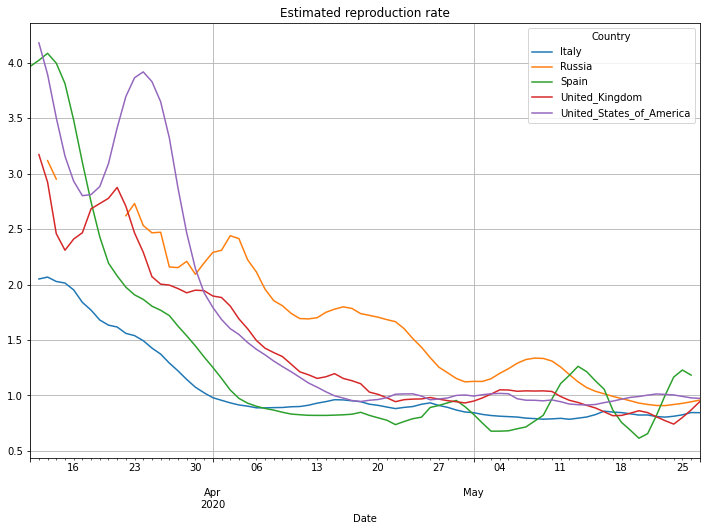

In [150]:
# delete the previous data
data.clear()
# the period, don't forget it doesn't make sense to calculate R for the exponential phase
lastNdays = 90
# collect the data for all country codes
for geoID in geoIDs:
    countryData = covidCases.get_country_data_by_geoID(geoID, lastNdays=lastNdays)
    # we will create 2 blocks and sum the data of each block
    blockSize = 4
    # for the first 2 blocks we don't get a result 
    for i in range(0, 2 * blockSize - 1):
        countryData[i].update({'R0': math.nan})
    for i in range(2 * blockSize - 1, lastNdays):
        # init the sum of each block
        sum0 = 0
        sum1 = 0
        for n in range(0, blockSize):
            # the index of the first block
            index0 = i - n
            # the index of the second block
            index1 = i - n - blockSize
            # the sum of each of the blocks
            sum0 = sum0 + int(countryData[index0]['Cases'])
            sum1 = sum1 + int(countryData[index1]['Cases'])
            #print ("data: " + str(i) + " index0: " + str(index0) + " index1: " + str(index1))
        # R based on the sum of the two blocks
        if sum1 == 0:
            R = math.nan
        else:
            R = sum0 / sum1
        # add the result to the dataset
        countryData[i].update({'R0': R})
        #print('0-3: ' + str(sum0) + ' 4-7: ' + str(sum1) + " R: " + str(R))
    # the size of a lowpass
    filterSize = 7
    # remember we don't have R for the first two blocks pluse the length of the filter
    offset = filterSize - 1 + 2 * blockSize - 1
    # we don't have a result for the first data
    for i in range(0, offset):
        countryData[i].update({'R0 filtered': math.nan})
    # enumarate the data
    for i in range(offset, lastNdays):
        # init the sum
        sum3 = 0
        # sum it up
        for n in range(0, filterSize):
            sum3 = sum3 + float(countryData[i - n]['R0'])
        # take the average
        sum3 = sum3 / filterSize
        # add it to the dataset
        countryData[i].update({'R0 filtered': sum3})
    data.append(countryData)
# get the data for all countries
dfdata = [pd.DataFrame(country_data) for country_data in data]
# concatinate to one list
df = pd.concat(dfdata)
# ensure the type of the 'Date' field
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
# plot filtered R0 cases
(PlotterBuilder('R0 filtered')
     .set_title('Estimated reproduction rate')
     #.set_xaxis_index()
     .set_grid()
     .set_axis_labels(xlabel="Last " + str(lastNdays) + " days")
     .plot_dataFrame(df))
